# 0. Подготовка окружения (загрузка моделей + вспомогательные функции)

In [37]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt

import random
from copy import deepcopy

import torch
import torch.nn.functional as F
from PIL import Image

import requests
from io import BytesIO

# Добавляем путь к репозиторию StyleGAN2
stylegan_path = os.path.abspath('stylegan2-ada-pytorch')
if stylegan_path not in sys.path:
    sys.path.insert(0, stylegan_path)

# Проверка устройства
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Устройство: {device}")

# Создаём папки для результатов, если их нет
os.makedirs('pictures', exist_ok=True)
os.makedirs('models', exist_ok=True)

Устройство: cuda


In [5]:
import dnnlib
import legacy

# URL весов FFHQ от NVlabs
ffhq_url = 'https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl'

def load_stylegan2_generator(url, device):
    with dnnlib.util.open_url(url) as f:
        generator = legacy.load_network_pkl(f)['G_ema'].to(device)
    generator.eval()
    return generator

# Загружаем базовый генератор
G_base = load_stylegan2_generator(ffhq_url, device)
print(f"Базовый генератор загружен. Разрешение: {G_base.img_resolution}x{G_base.img_resolution}")

Базовый генератор загружен. Разрешение: 1024x1024


In [6]:
RANDOM_SEED = 42

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [7]:
# В случае некритичных проблем с совместимостью CUDA, Visual Studio Build Tools и Torch
# этот код поможет для подавления вывода многочисленных предупреждений
import warnings

warnings.filterwarnings("ignore")

stylegan_path = os.path.abspath('stylegan2-ada-pytorch')
if stylegan_path not in sys.path:
    sys.path.insert(0, stylegan_path)

def apply_plugin_patches():
    try:
        from torch_utils.ops import upfirdn2d, bias_act

        def patched_upfirdn2d_init():
            return False

        def patched_bias_act_init():
            return False

        upfirdn2d._init = patched_upfirdn2d_init
        bias_act._init = patched_bias_act_init

        return True
    except Exception:
        return False

apply_plugin_patches()

True

In [8]:
def tensor_to_image(tensor):
    """
    Конвертирует тензор [-1, 1] -> PIL Image.
    """
    if tensor.ndim == 4:
        tensor = tensor[0]
    tensor = (tensor + 1) * 0.5
    tensor = torch.clamp(tensor, 0, 1)
    image = (tensor * 255).permute(1, 2, 0).detach().cpu().numpy().astype(np.uint8)
    return Image.fromarray(image)

def save_image_grid(images, filename, titles=None):
    """
    Сохраняет сетку изображений в файл.
    """
    n = len(images)
    cols = min(4, n)
    rows = (n + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 4 * rows))
    if rows == 1 and cols == 1:
        axes = np.array([[axes]])
    elif rows == 1 or cols == 1:
        axes = np.array(axes).reshape(rows, cols)

    for i in range(n):
        ax = axes[i // cols, i % cols]
        ax.imshow(images[i])
        ax.axis('off')
        if titles and i < len(titles):
            ax.set_title(titles[i], fontsize=10)

    # Скрываем пустые оси
    for i in range(n, rows * cols):
        axes[i // cols, i % cols].axis('off')

    plt.tight_layout()
    plt.savefig(filename, dpi=150, bbox_inches='tight')
    plt.close()

In [9]:
# Список обученных моделей (ожидаемые имена файлов)
model_configs = [
    ('anime', 'G_anime_drawing.pt'),
    ('sketch', 'G_sketch.pt'),
    ('watercolor', 'G_watercolor_painting.pt')
]

loaded_models = {}
missing_models = []

for name, filename in model_configs:
    filepath = os.path.join('models', filename)
    if os.path.exists(filepath):
        G = deepcopy(G_base)
        G.load_state_dict(torch.load(filepath, map_location=device))
        G = G.to(device)
        G.eval()
        loaded_models[name] = G
        print(f"Загружена модель '{name}' из {filename}")
    else:
        missing_models.append((name, filename))
        print(f"Файл не найден: {filename}")

if not loaded_models:
    print("\nНи одна обученная модель не найдена в папке 'models/'")
    print("   Проверьте наличие файлов: models/G_anime_drawing.pt, models/G_sketch.pt, models/G_watercolor_painting.pt")
else:
    print(f"\nЗагружено моделей: {len(loaded_models)}")

Загружена модель 'anime' из G_anime_drawing.pt
Загружена модель 'sketch' из G_sketch.pt
Загружена модель 'watercolor' из G_watercolor_painting.pt

Загружено моделей: 3


# 3.1 Редактирование сгенерированных изображений

In [17]:
def generate_comparison_pair(generator_base, generator_style, seed=123, num_images=4):
    """
    Генерирует пары изображений: базовое (фото) и стилизованное.
    """
    torch.manual_seed(seed)
    z = torch.randn(num_images, generator_base.z_dim).to(device)

    with torch.no_grad():
        imgs_base = generator_base(z, c=None, truncation_psi=0.7)
        imgs_style = generator_style(z, c=None, truncation_psi=0.7)

    return imgs_base, imgs_style

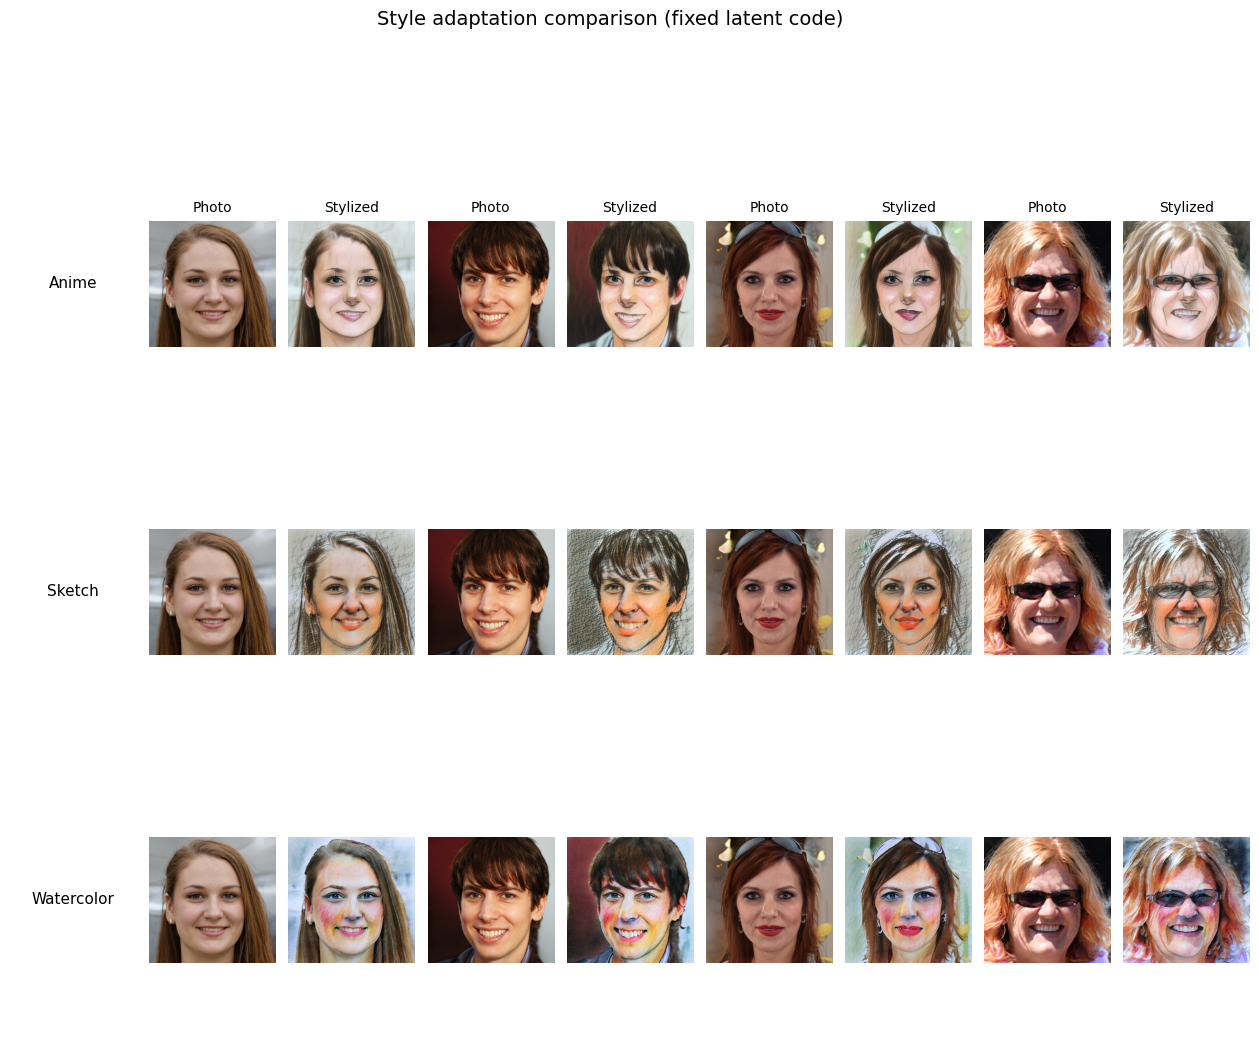

Результаты сохранены: pictures/generated_styles.png


In [27]:
# Параметры визуализации
seed_vis = RANDOM_SEED
num_images = 4
style_names = list(loaded_models.keys())

if not style_names:
    print("Нет загруженных моделей для визуализации")
else:
    # Создаём сетку: строки = число стилей, столбцы = 1 (подпись) + num_images * 2 (пары до/после)
    fig = plt.figure(figsize=(16, 4 * len(style_names)))
    gs = fig.add_gridspec(len(style_names), num_images * 2 + 1, hspace=0.0, wspace=0.1)

    for idx, style_name in enumerate(style_names):
        G_style = loaded_models[style_name]

        # Генерация пар изображений
        imgs_base, imgs_style = generate_comparison_pair(
            G_base, G_style, seed=seed_vis, num_images=num_images
        )

        # Подпись стиля в первом столбце
        ax_label = fig.add_subplot(gs[idx, 0])
        ax_label.text(0.5, 0.5, style_name.capitalize(),
                     ha='center', va='center', fontsize=11)
        ax_label.axis('off')

        # Пары изображений "до" и "после"
        for i in range(num_images):
            # Базовое изображение (фото)
            ax_before = fig.add_subplot(gs[idx, 2*i + 1])
            img_before = tensor_to_image(imgs_base[i])
            ax_before.imshow(img_before)
            ax_before.axis('off')
            if idx == 0:
                ax_before.set_title('Photo', fontsize=10)

            # Стилизованное изображение
            ax_after = fig.add_subplot(gs[idx, 2*i + 2])
            img_after = tensor_to_image(imgs_style[i])
            ax_after.imshow(img_after)
            ax_after.axis('off')
            if idx == 0:
                ax_after.set_title('Stylized', fontsize=10)

    plt.suptitle('Style adaptation comparison (fixed latent code)',
                 fontsize=14)
    plt.savefig('pictures/generated_styles.png', bbox_inches='tight')
    plt.show()

    print("Результаты сохранены: pictures/generated_styles.png")

# 3.2 Редактирование реальных изображений

In [40]:
# Для демонстрации были загружены и сохранены в папке /pictures/ несколько изображений известных личностей

In [41]:
image_filenames = ['hepburn.png', 'junger.png', 'steel.png', 'lynch.png']
real_image_paths = [f'pictures/{fname}' for fname in image_filenames]

In [43]:
def preprocess_face_image(image_path, target_size=1024):
    """
    Предобработка изображения лица для инверсии:
    1. Загрузка и конвертация в RGB
    2. Обрезка до квадрата по центру
    3. Изменение размера до target_size
    """
    img_pil = Image.open(image_path).convert('RGB')

    # Обрезка до квадрата по центру
    width, height = img_pil.size
    min_dim = min(width, height)
    left = (width - min_dim) // 2
    top = (height - min_dim) // 2
    img_cropped = img_pil.crop((left, top, left + min_dim, top + min_dim))

    # Изменение размера до 1024x1024
    img_resized = img_cropped.resize((target_size, target_size), Image.LANCZOS)

    return img_resized

In [45]:
# Предобработка и сохранение выровненных изображений
aligned_paths = []
for path in real_image_paths:
    try:
        img_aligned = preprocess_face_image(path, target_size=1024)
        base_name = os.path.basename(path)
        aligned_path = f'pictures/aligned_{base_name}'
        img_aligned.save(aligned_path)
        aligned_paths.append(aligned_path)
        print(f"Обработано: {base_name} -> aligned_{base_name}")
    except Exception as e:
        print(f"Ошибка обработки {path}: {e}")

Обработано: hepburn.png -> aligned_hepburn.png
Обработано: junger.png -> aligned_junger.png
Обработано: steel.png -> aligned_steel.png
Обработано: lynch.png -> aligned_lynch.png


Инверсия реальных изображений (градиентная оптимизация)

In [47]:
def invert_image(image_path, generator, steps=500, lr=0.05, seed=RANDOM_SEED):
    """
    Инверсия изображения в W-пространство.
    """
    img_pil = Image.open(image_path).convert('RGB')

    img_tensor = torch.from_numpy(np.array(img_pil)).permute(2, 0, 1).float().to(device)
    img_tensor = img_tensor / 127.5 - 1.0
    img_tensor = img_tensor.unsqueeze(0)

    torch.manual_seed(seed)
    w_avg = generator.mapping.w_avg
    w_opt = w_avg.clone().detach().requires_grad_(True)

    optimizer = torch.optim.Adam([w_opt], lr=lr)

    print(f"\nИнверсия: {os.path.basename(image_path)} | шагов: {steps}")

    for step in range(steps):
        w_broadcast = w_opt.repeat(generator.synthesis.num_ws, 1).unsqueeze(0)
        synth_img = generator.synthesis(w_broadcast, noise_mode='const')
        loss = F.mse_loss(synth_img, img_tensor)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if step % 100 == 0 or step == steps - 1:
            print(f"  Шаг {step+1:3d}/{steps} | loss: {loss.item():.6f}", flush=True)

    return w_opt.detach()

def edit_with_generator(w_vector, generator):
    """
    Применение стиля к инвертированному вектору.
    """
    w_broadcast = w_vector.repeat(generator.synthesis.num_ws, 1).unsqueeze(0)
    with torch.no_grad():
        img_edited = generator.synthesis(w_broadcast, noise_mode='const')
    return img_edited

In [48]:
# Инверсия и редактирование первых 3 изображений
inversion_results = []

for img_path in aligned_paths:  # Обрабатываем все 4 изображения
    # Оригинал для отображения (уменьшаем до 256px)
    img_original = Image.open(img_path).convert('RGB').resize((256, 256), Image.LANCZOS)

    # Инверсия
    w_vector = invert_image(img_path, G_base, steps=500, lr=0.05, seed=42)

    # Реконструкция
    with torch.no_grad():
        w_broadcast = w_vector.repeat(G_base.synthesis.num_ws, 1).unsqueeze(0)
        img_recon = G_base.synthesis(w_broadcast, noise_mode='const')
    img_recon_pil = tensor_to_image(img_recon).resize((256, 256), Image.LANCZOS)

    # Редактирование через обученные генераторы
    edited_images = []
    for name in loaded_models.keys():
        img_edited = edit_with_generator(w_vector, loaded_models[name])
        img_edited_pil = tensor_to_image(img_edited).resize((256, 256), Image.LANCZOS)
        edited_images.append(img_edited_pil)

    inversion_results.append({
        'original': img_original,
        'reconstruction': img_recon_pil,
        'edited': edited_images
    })



Инверсия: aligned_hepburn.png | шагов: 500
  Шаг   1/500 | loss: 0.512422
  Шаг 101/500 | loss: 0.131526
  Шаг 201/500 | loss: 0.073854
  Шаг 301/500 | loss: 0.066873
  Шаг 401/500 | loss: 0.051888
  Шаг 500/500 | loss: 0.044868

Инверсия: aligned_junger.png | шагов: 500
  Шаг   1/500 | loss: 0.584095
  Шаг 101/500 | loss: 0.093897
  Шаг 201/500 | loss: 0.058570
  Шаг 301/500 | loss: 0.053107
  Шаг 401/500 | loss: 0.046592
  Шаг 500/500 | loss: 0.042044

Инверсия: aligned_steel.png | шагов: 500
  Шаг   1/500 | loss: 0.462115
  Шаг 101/500 | loss: 0.041604
  Шаг 201/500 | loss: 0.031171
  Шаг 301/500 | loss: 0.026995
  Шаг 401/500 | loss: 0.025159
  Шаг 500/500 | loss: 0.023619

Инверсия: aligned_lynch.png | шагов: 500
  Шаг   1/500 | loss: 0.457898
  Шаг 101/500 | loss: 0.120861
  Шаг 201/500 | loss: 0.078117
  Шаг 301/500 | loss: 0.056555
  Шаг 401/500 | loss: 0.054394
  Шаг 500/500 | loss: 0.075597


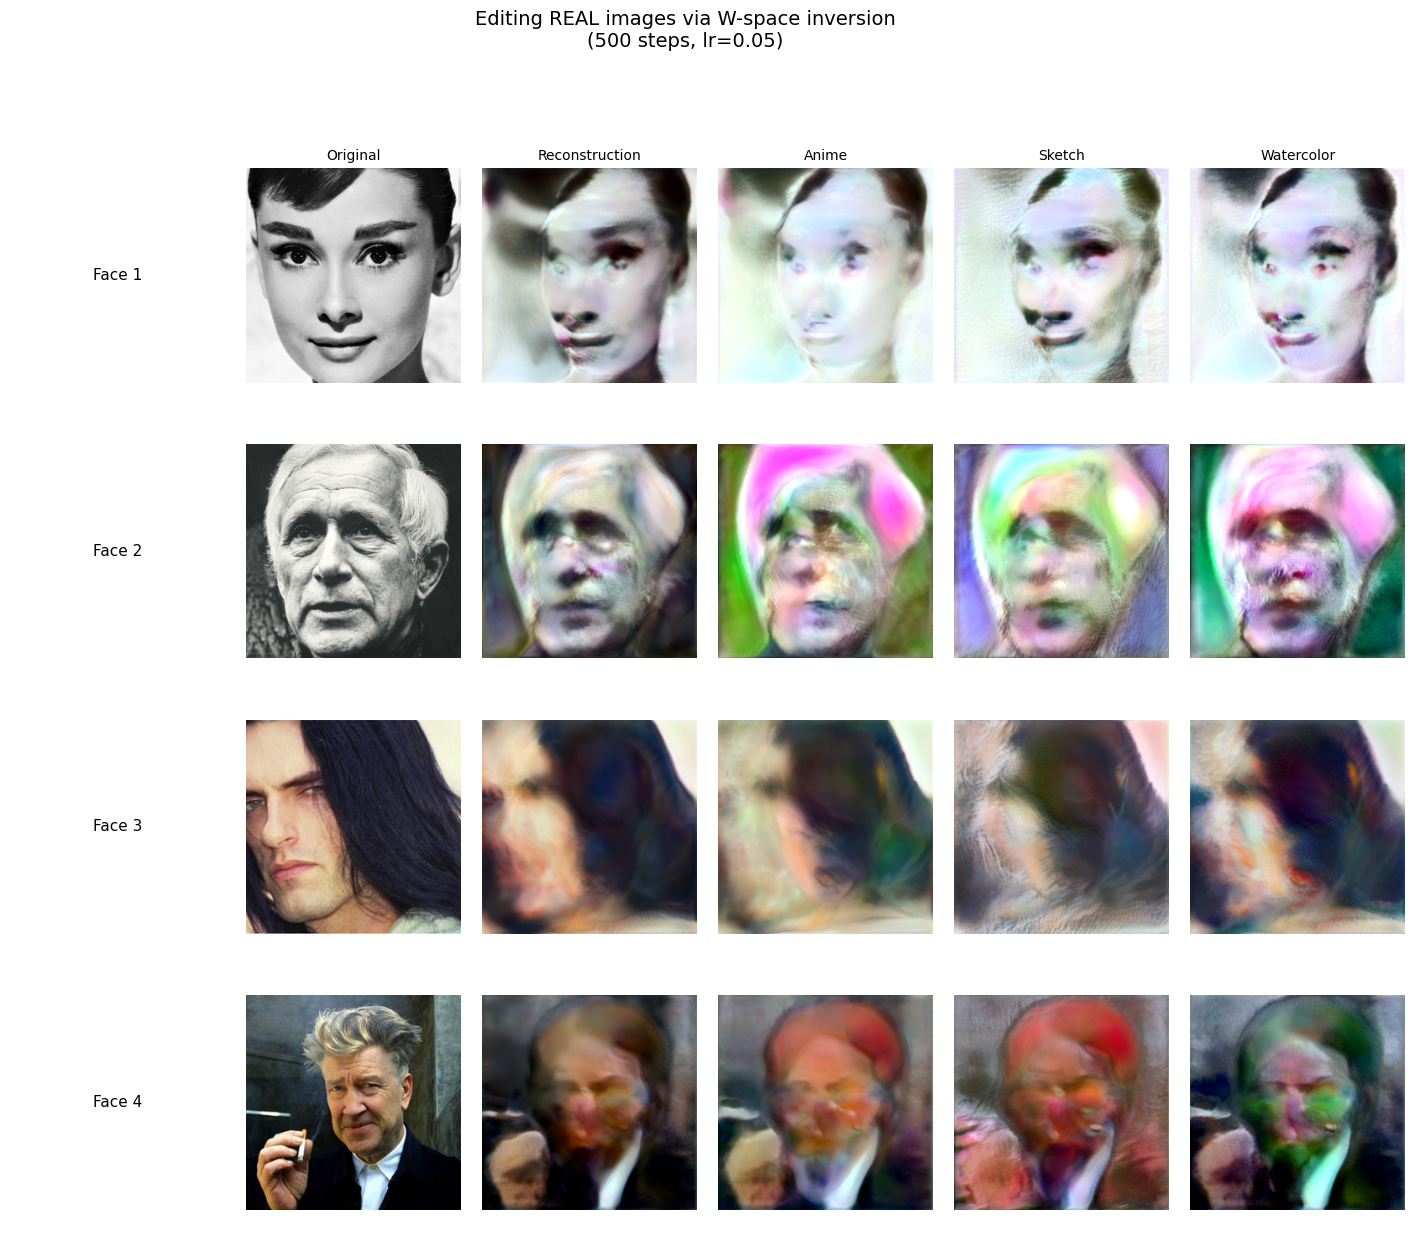


Результат сохранён: pictures/real_image_editing.png

Обработано изображений: 4
  1. aligned_hepburn.png
  2. aligned_junger.png
  3. aligned_steel.png
  4. aligned_lynch.png


In [51]:
# Визуализация для 4 изображений
num_images = len(inversion_results)  # = 4
num_styles = len(loaded_models)
style_names = list(loaded_models.keys())

if num_images > 0:
    # Структура: строки = изображения (4), столбцы = 1 (подпись) + 1 (оригинал) + 1 (реконструкция) + число стилей
    fig = plt.figure(figsize=(3 * (3 + num_styles), 3.5 * num_images))
    gs = fig.add_gridspec(num_images, 3 + num_styles, hspace=0.1, wspace=0.1)

    for row_idx in range(num_images):
        result = inversion_results[row_idx]

        # Подпись изображения (первый столбец)
        ax_label = fig.add_subplot(gs[row_idx, 0])
        ax_label.text(0.5, 0.5, f'Face {row_idx+1}',
                     ha='center', va='center', fontsize=11)
        ax_label.axis('off')

        # Исходное изображение (второй столбец)
        ax_orig = fig.add_subplot(gs[row_idx, 1])
        ax_orig.imshow(result['original'])
        ax_orig.axis('off')
        if row_idx == 0:
            ax_orig.set_title('Original', fontsize=10)

        # Реконструкция (третий столбец)
        ax_recon = fig.add_subplot(gs[row_idx, 2])
        ax_recon.imshow(result['reconstruction'])
        ax_recon.axis('off')
        if row_idx == 0:
            ax_recon.set_title('Reconstruction', fontsize=10)

        # Стилизованные версии (остальные столбцы)
        for col_idx, style_name in enumerate(style_names):
            ax_edit = fig.add_subplot(gs[row_idx, 3 + col_idx])
            ax_edit.imshow(result['edited'][col_idx])
            ax_edit.axis('off')
            if row_idx == 0:
                ax_edit.set_title(style_name.capitalize(), fontsize=10)

    plt.suptitle('Editing REAL images via W-space inversion\n(500 steps, lr=0.05)',
                 fontsize=14)
    plt.savefig('pictures/real_image_editing.png', bbox_inches='tight')
    plt.show()

    print("\nРезультат сохранён: pictures/real_image_editing.png")
    print("\nОбработано изображений: 4")
    for i, path in enumerate(aligned_paths):
        print(f"  {i+1}. {os.path.basename(path)}")